C:\Users\wsfm\AppData\Local\Temp\ipykernel_19964\4080975961.py:44: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  s1["date_dt"] = pd.to_datetime(s1["date"])
C:\Users\wsfm\AppData\Local\Temp\ipykernel_19964\4080975961.py:45: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  s2["date_dt"] = pd.to_datetime(s2["date"])


Selected dates per subplot (series → date):
  January   s1=2018-01-28 00:00:00 | s2=2018-01-28 00:00:00
  April     s1=2018-04-21 00:00:00 | s2=2018-04-20 00:00:00
  July      s1=2018-07-13 00:00:00 | s2=2018-07-13 00:00:00
  October   s1=2018-10-06 00:00:00 | s2=2018-10-13 00:00:00
Saved: C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/v_results_4_output\Figure_4_4_1_4_4_2_merged.png and C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/v_results_4_output\Figure_4_4_1_4_4_2_merged.svg


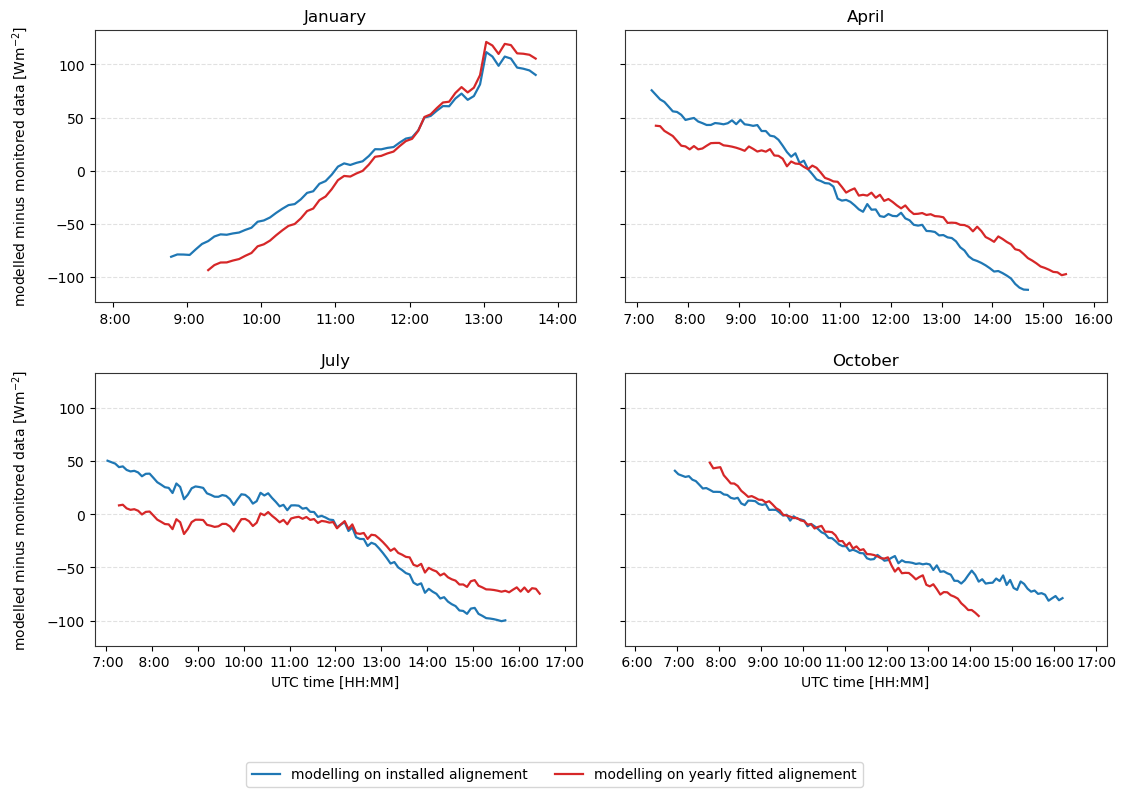

In [13]:
import os

# ------------------------------------------------------------
# Output
# ------------------------------------------------------------

BASE_DIR= r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/"
OUT_DIR = os.path.join(BASE_DIR,"v_results_4_output")
INP_DIR = os.path.join(BASE_DIR,"assets","alignment")
CSV_INST = "lazio1t30a180s0n3.csv"
CSV_FIT  = 'lazio1t28a211s0n3.csv'

# -*- coding: utf-8 -*-
"""
Merged alignment figure from CSVs in INP_DIR.

Updates in this version:
• Y-label appears only on the left column subplots.
• Bottom row x-axis explicitly states: UTC time [HH:MM].
• X-axis ticks are forced to one-per-hour and formatted as “8 :00”, “9 :00”, …
  (no drift, no 50-minute alternation).
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------------------
# Assumed provided in your environment (same names you used before):
# BASE_DIR = r"..."
# INP_DIR  = os.path.join(BASE_DIR, "assets")
# OUT_DIR  = os.path.join(BASE_DIR, "v_results_3_output")
# CSV_INST = "fmc1t30a180s0n3.csv"   # installation-orientation export
# CSV_FIT  = "fmc1t28a211s0n3.csv"   # fitted-orientation export
# ------------------------------------------------------------------

# --------------------------- Load CSVs ---------------------------
s1 = pd.read_csv(os.path.join(INP_DIR, CSV_INST))
s2 = pd.read_csv(os.path.join(INP_DIR, CSV_FIT))

# Ensure date typed
s1["date_dt"] = pd.to_datetime(s1["date"])
s2["date_dt"] = pd.to_datetime(s2["date"])

# Normalize x-axis label from 'hour_minute' → HH:MM and create sortable key
def prep_time(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["hour_minute"] = df["hour_minute"].astype(str)
    # show as HH:MM (trim seconds if present)
    df["hhmm"] = df["hour_minute"].str.slice(0, 5)
    # minutes-of-day key (HH*60 + MM); invalid -> NaT -> dropped later
    hh = pd.to_datetime(df["hhmm"], format="%H:%M", errors="coerce")
    df["minutes_of_day"] = hh.dt.hour * 60 + hh.dt.minute
    return df

s1 = prep_time(s1)
s2 = prep_time(s2)

# -------------------------- Target days & fallback --------------------------
targets = [
    ("January",  1, {"s1": pd.Timestamp("2018-01-20"), "s2": pd.Timestamp("2018-01-20")}),
    ("April",    4, {"s1": pd.Timestamp("2018-04-21"), "s2": pd.Timestamp("2018-04-20")}),
    ("July",     7, {"s1": pd.Timestamp("2018-07-13"), "s2": pd.Timestamp("2018-07-13")}),
    ("October", 10, {"s1": pd.Timestamp("2018-10-03"), "s2": pd.Timestamp("2018-10-13")}),
]

def choose_in_month(df: pd.DataFrame, month: int, target_dt: pd.Timestamp):
    candidates = (df.loc[df["date_dt"].dt.month == month, "date_dt"]
                    .drop_duplicates().sort_values().to_list())
    if not candidates:
        return None
    if target_dt in candidates:
        return target_dt
    return min(candidates, key=lambda d: abs((d - target_dt).days))

used_dates = {"s1": {}, "s2": {}}
for name, month, t in targets:
    used_dates["s1"][name] = choose_in_month(s1, month, t["s1"])
    used_dates["s2"][name] = choose_in_month(s2, month, t["s2"])

print("Selected dates per subplot (series → date):")
for name, _, _ in targets:
    print(f"  {name:<8}  s1={used_dates['s1'][name]} | s2={used_dates['s2'][name]}")

# ------------------------------- Plotting -------------------------------
plt.rcParams.update({
    "axes.edgecolor": "#333",
    "axes.linewidth": 0.8,
    "grid.color": "#bdbdbd",
    "grid.linestyle": "--",
    "grid.alpha": 0.45,
    "axes.grid": True,
    "font.size": 10,
})

fig, axes = plt.subplots(2, 2, figsize=(11.5, 7.8), sharex=False, sharey=True)
axes = axes.ravel()

# Colors & labels
COL_INST = "#1f77b4"  # installation (series s1)
COL_FIT  = "#d62728"  # fitted      (series s2)
LAB_INST = "modelling on installed alignement"
LAB_FIT  = "modelling on yearly fitted alignement"

# Proxies for one figure-level legend
proxy_inst, = plt.plot([], [], color=COL_INST, linewidth=1.6)
proxy_fit,  = plt.plot([], [], color=COL_FIT,  linewidth=1.6)

def hour_ticks_from_time_span(mins_min: int, mins_max: int):
    """
    Build hourly tick positions (in minutes-of-day) and labels like '8 :00'
    spanning [mins_min, mins_max].
    """
    if not np.isfinite(mins_min) or not np.isfinite(mins_max):
        return [], []
    # floor to previous whole hour, ceil to next whole hour
    h_start = int(np.floor(mins_min / 60.0))
    h_end   = int(np.ceil (mins_max / 60.0))
    if h_end < h_start:
        h_end = h_start
    positions = [h * 60 for h in range(h_start, h_end + 1)]
    # label style "8 :00" (space before colon as requested)
    labels = [f"{h:>2d}:00" for h in range(h_start, h_end + 1)]
    return positions, labels

for idx, (ax, (name, month, _)) in enumerate(zip(axes, targets)):
    d1 = used_dates["s1"][name]
    d2 = used_dates["s2"][name]

    # filter and sort
    sub1 = (s1.loc[s1["date_dt"] == d1, ["hhmm", "minutes_of_day", "difference"]]
              .dropna(subset=["minutes_of_day"])
              .sort_values("minutes_of_day")) if d1 is not None else pd.DataFrame(columns=["minutes_of_day","difference"])
    sub2 = (s2.loc[s2["date_dt"] == d2, ["hhmm", "minutes_of_day", "difference"]]
              .dropna(subset=["minutes_of_day"])
              .sort_values("minutes_of_day")) if d2 is not None else pd.DataFrame(columns=["minutes_of_day","difference"])

    # Plot series
    if not sub1.empty:
        ax.plot(sub1["minutes_of_day"], sub1["difference"], color=COL_INST, linewidth=1.6)
    if not sub2.empty:
        ax.plot(sub2["minutes_of_day"], sub2["difference"], color=COL_FIT,  linewidth=1.6)

    # X ticks: one per hour, formatted as '8 :00'
    if not sub1.empty or not sub2.empty:
        mins_all = pd.concat([sub1["minutes_of_day"], sub2["minutes_of_day"]], axis=0)
        xmin, xmax = int(mins_all.min()), int(mins_all.max())
        tick_pos, tick_lab = hour_ticks_from_time_span(xmin, xmax)
        if tick_pos:
            ax.set_xticks(tick_pos)
            ax.set_xticklabels(tick_lab)
            # small margins
            ax.set_xlim(tick_pos[0] - 15, tick_pos[-1] + 15)

    # Titles: month
    ax.set_title(name)

    # Y-label only on the LEFT column (indices 0 and 2)
    if idx in (0, 2):
        ax.set_ylabel("modelled minus monitored data [Wm$^{-2}$]",
                      fontsize=10, labelpad=12)
    else:
        ax.set_ylabel("")

    # X-label only on BOTTOM row: specify UTC
    if idx in (2, 3):
        ax.set_xlabel("UTC time [HH:MM]")
    else:
        ax.set_xlabel("")

    # Grid: Y only (cleaner)
    ax.grid(True, axis="y"); ax.grid(False, axis="x")

# Legend: bring it close under the panels
fig.legend([proxy_inst, proxy_fit], [LAB_INST, LAB_FIT],
           loc="upper center", bbox_to_anchor=(0.5, 0.02),
           ncol=2, frameon=True)

# Layout
fig.subplots_adjust(wspace=0.10, hspace=0.26, bottom=0.16, left=0.10, right=0.98, top=0.95)

# Save
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
png = os.path.join(OUT_DIR, "Figure_4_4_1_4_4_2_merged.png")
svg = os.path.join(OUT_DIR, "Figure_4_4_1_4_4_2_merged.svg")
fig.savefig(png, dpi=300)
fig.savefig(svg)
print(f"Saved: {png} and {svg}")

C:\Users\wsfm\AppData\Local\Temp\ipykernel_14732\1599676255.py:33: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  s1["date_dt"] = pd.to_datetime(s1["date"], errors="coerce")
C:\Users\wsfm\AppData\Local\Temp\ipykernel_14732\1599676255.py:34: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  s2["date_dt"] = pd.to_datetime(s2["date"], errors="coerce")


Selected dates per subplot (series → date):
  January   s1=2018-01-28 00:00:00 | s2=2018-01-28 00:00:00
  April     s1=2018-04-21 00:00:00 | s2=2018-04-20 00:00:00
  July      s1=2018-07-13 00:00:00 | s2=2018-07-13 00:00:00
  October   s1=2018-10-06 00:00:00 | s2=2018-10-13 00:00:00
Saved: C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/v_results_4_output\Figure_4_4_merged_with_fitted_irradiance.png and C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/v_results_4_output\Figure_4_4_merged_with_fitted_irradiance.svg


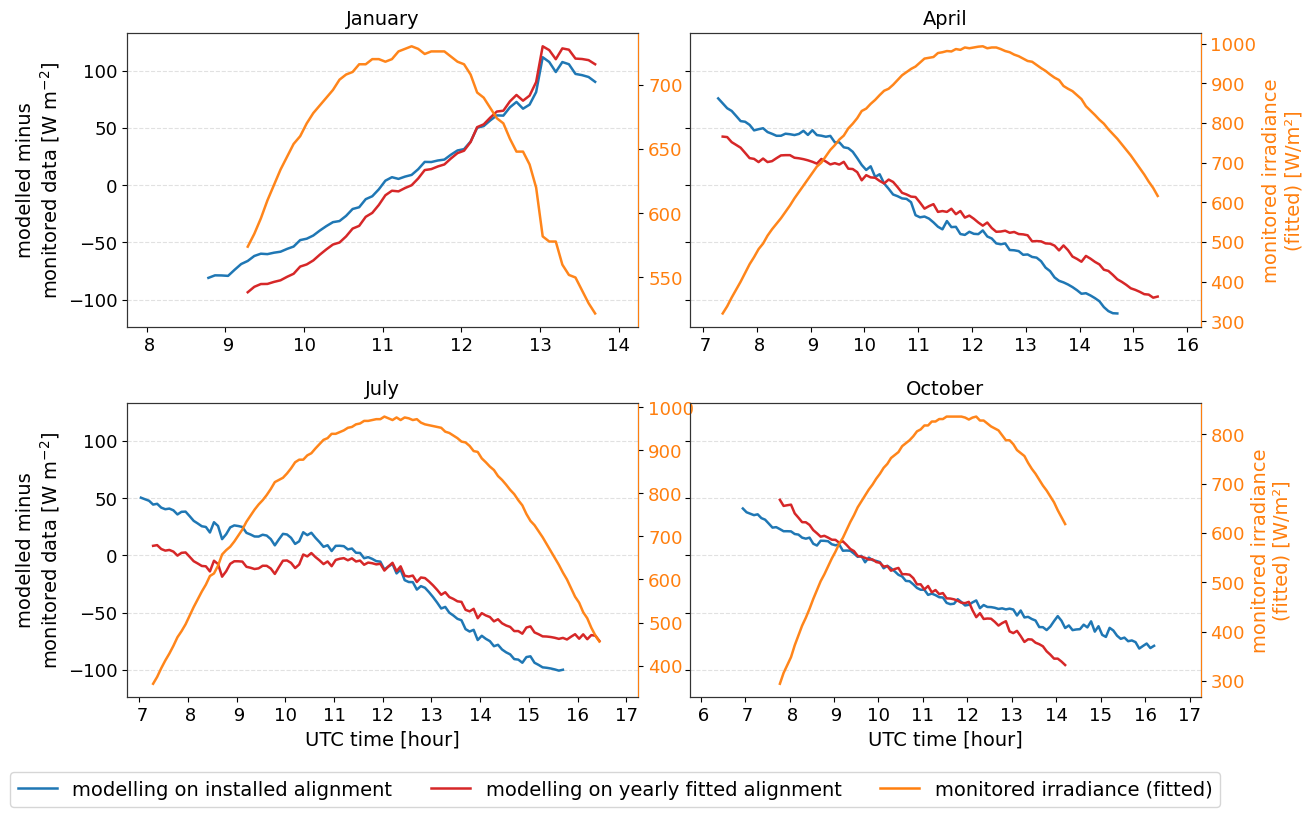

In [1]:
# -*- coding: utf-8 -*-
"""
Merged alignment figure (4.4.1 & 4.4.2) — upgraded with:
  • FONTSIZE global typography
  • Secondary y-axis (orange) for monitored irradiance from FITTED CSV
  • Legend now includes the orange irradiance entry
  • Secondary y-axis label and ticks colored orange for clarity
"""

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --------------------------- GLOBAL FONT CONTROL ---------------------------
FONTSIZE = 14  # titles/labels/legend follow this; tick labels use max(FONTSIZE-1, 8)

# --------------------------- Paths & inputs ---------------------------
BASE_DIR = r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/"
OUT_DIR  = os.path.join(BASE_DIR, "v_results_4_output")
INP_DIR  = os.path.join(BASE_DIR, "assets", "alignment")

CSV_INST = "lazio1t30a180s0n3.csv"   # installed alignment (differences)
CSV_FIT  = "lazio1t28a211s0n3.csv"   # yearly fitted alignment (differences + irradiance)

# --------------------------- Load CSVs ---------------------------
s1 = pd.read_csv(os.path.join(INP_DIR, CSV_INST), dtype=str)  # installation alignment
s2 = pd.read_csv(os.path.join(INP_DIR, CSV_FIT),  dtype=str)  # yearly fitted alignment

# Parse dates
s1["date_dt"] = pd.to_datetime(s1["date"], errors="coerce")
s2["date_dt"] = pd.to_datetime(s2["date"], errors="coerce")

# Normalize 'hour_minute' and 'difference'
def prep_time(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["hour_minute"] = out["hour_minute"].astype(str)
    out["hhmm"] = out["hour_minute"].str.slice(0, 5)  # 'HH:MM'
    hh = pd.to_datetime(out["hhmm"], format="%H:%M", errors="coerce")
    out["minutes_of_day"] = hh.dt.hour * 60 + hh.dt.minute
    if "difference" in out.columns:
        out["difference"] = pd.to_numeric(
            out["difference"].astype(str)
                .str.replace("\u00A0","", regex=False).str.replace(" ", "", regex=False)
                .str.replace(",", ".", regex=False),
            errors="coerce"
        )
    return out

s1 = prep_time(s1)
s2 = prep_time(s2)

# --------------------------- Irradiance resolver (from FITTED CSV) ---------------------------
def resolve_irr_column(columns):
    preferred = [
        "Pyranometer Cab 1 Irradiance [W/sqm]",
        "Pyranometer Cab 1 Irradiance [W/m2]",
        "Piranometer Cab 1 Irradiance [W/sqm]",
        "Piranometer Cab 1 Irradiance [W/m2]",
        "Measured",
    ]
    low = {c.lower(): c for c in columns}
    for cand in preferred:
        if cand.lower() in low: return low[cand.lower()]
    for k, v in low.items():
        if "irradiance" in k: return v
    return None

IRR_COL_FIT = resolve_irr_column(s2.columns)
if IRR_COL_FIT is None:
    print("[WARN] No irradiance column detected in FITTED CSV; secondary curve may be omitted.")

def clean_numeric(series: pd.Series) -> pd.Series:
    return pd.to_numeric(
        series.astype(str)
              .str.replace("\u00A0","", regex=False).str.replace(" ", "", regex=False)
              .str.replace(",", ".", regex=False),
        errors="coerce"
    )

# -------------------------- Target months & fallback day choice --------------------------
targets = [
    ("January",  1, {"s1": pd.Timestamp("2018-01-20"), "s2": pd.Timestamp("2018-01-20")}),
    ("April",    4, {"s1": pd.Timestamp("2018-04-21"), "s2": pd.Timestamp("2018-04-20")}),
    ("July",     7, {"s1": pd.Timestamp("2018-07-13"), "s2": pd.Timestamp("2018-07-13")}),
    ("October", 10, {"s1": pd.Timestamp("2018-10-03"), "s2": pd.Timestamp("2018-10-13")}),
]

def choose_in_month(df: pd.DataFrame, month: int, target_dt: pd.Timestamp):
    candidates = (df.loc[df["date_dt"].dt.month == month, "date_dt"]
                    .drop_duplicates().sort_values().to_list())
    if not candidates:
        return None
    return target_dt if target_dt in candidates else min(candidates, key=lambda d: abs((d - target_dt).days))

used_dates = {"s1": {}, "s2": {}}
for name, month, t in targets:
    used_dates["s1"][name] = choose_in_month(s1, month, t["s1"])
    used_dates["s2"][name] = choose_in_month(s2, month, t["s2"])

print("Selected dates per subplot (series → date):")
for name, _, _ in targets:
    print(f"  {name:<8}  s1={used_dates['s1'][name]} | s2={used_dates['s2'][name]}")

# ------------------------------- Plotting -------------------------------
plt.rcParams.update({
    "axes.edgecolor": "#333",
    "axes.linewidth": 0.8,
    "grid.color": "#bdbdbd",
    "grid.linestyle": "--",
    "grid.alpha": 0.45,
    "axes.grid": True,      # grid on primary axes only
    "font.size": FONTSIZE,  # base font for legend/defaults
})

fig, axes = plt.subplots(2, 2, figsize=(12.2, 8.2), sharex=False, sharey=True)
axes = axes.ravel()

# Colors & labels
COL_INST = "#1f77b4"  # installed difference (s1)
COL_FIT  = "#d62728"  # yearly fitted difference (s2)
COL_IRR  = "#ff7f0e"  # irradiance (from s2)
LAB_INST = "modelling on installed alignment"
LAB_FIT  = "modelling on yearly fitted alignment"
LAB_IRR  = "monitored irradiance (fitted)"

# Legend proxies (now includes irradiance)
proxy_inst, = plt.plot([], [], color=COL_INST, linewidth=1.8)
proxy_fit,  = plt.plot([], [], color=COL_FIT,  linewidth=1.8)
proxy_irr,  = plt.plot([], [], color=COL_IRR,  linewidth=1.8)

def hour_ticks_from_span(mins_min: int, mins_max: int):
    if not np.isfinite(mins_min) or not np.isfinite(mins_max):
        return [], []
    h_start = int(np.floor(mins_min / 60.0))
    h_end   = int(np.ceil (mins_max / 60.0))
    if h_end < h_start: h_end = h_start
    pos = [h*60 for h in range(h_start, h_end + 1)]
    lab = [f"{h:>2d}" for h in range(h_start, h_end + 1)]
    return pos, lab

for idx, (ax, (name, month, _)) in enumerate(zip(axes, targets)):
    d1 = used_dates["s1"][name]
    d2 = used_dates["s2"][name]

    # ---- primary axis: two 'difference' curves ----
    sub1 = (s1.loc[s1["date_dt"] == d1, ["minutes_of_day","difference"]]
              .dropna().sort_values("minutes_of_day")) if d1 is not None else pd.DataFrame()
    sub2 = (s2.loc[s2["date_dt"] == d2, ["minutes_of_day","difference"]]
              .dropna().sort_values("minutes_of_day")) if d2 is not None else pd.DataFrame()

    if not sub1.empty:
        ax.plot(sub1["minutes_of_day"], sub1["difference"], color=COL_INST, linewidth=1.8)
    if not sub2.empty:
        ax.plot(sub2["minutes_of_day"], sub2["difference"], color=COL_FIT,  linewidth=1.8)

    # ---- secondary axis: irradiance from the FITTED CSV (orange) ----
    ax2 = None
    irr_df = pd.DataFrame()
    if IRR_COL_FIT and d2 is not None:
        irr_df = (s2.loc[s2["date_dt"] == d2, ["minutes_of_day", IRR_COL_FIT]]
                    .dropna().sort_values("minutes_of_day").copy())
        irr_df.rename(columns={IRR_COL_FIT: "irr"}, inplace=True)
        irr_df["irr"] = clean_numeric(irr_df["irr"])
        irr_df = irr_df.dropna(subset=["irr"])

    if not irr_df.empty:
        ax2 = ax.twinx()
        ax2.grid(False)
        ax2.plot(irr_df["minutes_of_day"], irr_df["irr"], color=COL_IRR, linewidth=1.8, alpha=0.95)
        # Secondary y-label only on RIGHT subplots; color and tick color in orange
        if idx in (1, 3):
            ax2.set_ylabel("monitored irradiance\n(fitted) [W/m²]", color=COL_IRR, fontsize=FONTSIZE)
        ax2.tick_params(axis="y", labelcolor=COL_IRR, labelsize=max(FONTSIZE-1, 8))
        ax2.spines["right"].set_color(COL_IRR)

    # ---- X ticks & limits from union (incl. irradiance) ----
    mins_all_series = []
    if not sub1.empty:  mins_all_series.append(sub1["minutes_of_day"])
    if not sub2.empty:  mins_all_series.append(sub2["minutes_of_day"])
    if not irr_df.empty: mins_all_series.append(irr_df["minutes_of_day"])

    if mins_all_series:
        mins_all = pd.concat(mins_all_series).dropna()
        xmin, xmax = int(mins_all.min()), int(mins_all.max())
        ticks, labs = hour_ticks_from_span(xmin, xmax)
        if ticks:
            ax.set_xticks(ticks)
            ax.set_xticklabels(labs, fontsize=max(FONTSIZE-1, 8))
            ax.set_xlim(ticks[0] - 15, ticks[-1] + 15)

    # ---- titles & labels ----
    ax.set_title(name, fontsize=FONTSIZE)
    if idx in (0, 2):
        ax.set_ylabel("modelled minus\nmonitored data [W m$^{-2}$]", fontsize=FONTSIZE)
    else:
        ax.set_ylabel("")
    if idx in (2, 3):
        ax.set_xlabel("UTC time [hour]", fontsize=FONTSIZE)
    else:
        ax.set_xlabel("")
    ax.tick_params(axis="both", labelsize=max(FONTSIZE-1, 8))
    ax.grid(True, axis="y"); ax.grid(False, axis="x")

# ---- Figure-level legend (now includes irradiance), close under the panels ----
fig = plt.gcf()
fig.legend(
    [proxy_inst, proxy_fit, proxy_irr],
    [LAB_INST, LAB_FIT, LAB_IRR],
    loc="upper center",
    bbox_to_anchor=(0.5, 0.06),    # closer to the plots than before
    ncol=3, frameon=True, fontsize=FONTSIZE
)

# Layout & save
fig.subplots_adjust(
    wspace=0.10, hspace=0.26,
    bottom=0.14,   # less whitespace, since legend is closer
    left=0.10, right=0.98, top=0.95
)

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
png = os.path.join(OUT_DIR, "Figure_4_4_merged_with_fitted_irradiance.png")
svg = os.path.join(OUT_DIR, "Figure_4_4_merged_with_fitted_irradiance.svg")
fig.savefig(png, dpi=300)
fig.savefig(svg)
print(f"Saved: {png} and {svg}")